# Pytorch Lab: GLM
# HW 7
## 학과: 경영학부
## 학번: 1985084
## 이름: 임수지

# 4 More HW problems

## 4.1 HW problem 


We consider the Boston housing data, where the response variable is the median house value `medv` (in \$1000s). We want to model `medv` using the predictors `lstat` (lower status of the population, in %) and `age` (proportion of units built prior to 1940).

Train two models and compare the test mean squared error (MSE) of the following two models.

**Model 1 (two predictors)**  
We fit the linear regression model
$$
\texttt{medv}_i \sim N(\beta_0 + \beta_1\,\texttt{lstat}_i + \beta_2\,\texttt{age}_i,\, \sigma^2),
\qquad i = 1, \ldots, n.
$$

**Model 2 (one predictor)**  
We fit the reduced model that uses `lstat` only:
$$
\texttt{medv}_i \sim N(\beta_0 + \beta_1\,\texttt{lstat}_i,\, \sigma^2),
\qquad i = 1, \ldots, n.
$$

Using the following custom layer 
```
class GaussianRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = 
        self.sigma = 

    def forward(self, X):
        mu = 
        return mu

    def loss(self, mu, y):
        ll = 
        nll = -torch.sum(ll)
        return nll

forward1 = GaussianRegModel(3)
forward2 = GaussianRegModel(2)
```

Hint: 
1. You first want to make dataset(s) and dataloader(s) first.
2. Use the below code to have the data.

In [28]:
import pandas as pd
import torch

# 1. Load CSV
df = pd.read_csv("Boston.csv")
# 보스턴 지역을 몇백 개로 나누고, 그 지역에서 사는 사람들의 평균 나이, 기초수급자 비율 두 가지 설명변수로, 반응 변수는 집값으로 하는 데이터.
# 집값이 비싼지 안 비싼지 분석하는 normal regression 문제.

# 2. Convert to tensor
data = torch.tensor(df.values, dtype=torch.float32)

# 3. Shuffle rows manually
n = data.shape[0]
perm = torch.randperm(n)

shuffled = data[perm]

# 4. Train/Test split (70% train, 30% test)
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# 5. Split into X and y
X_train = train[:, :-1]
y_train = train[:, -1:]

X_test = test[:, :-1]
y_test = test[:, -1:]

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Train X: torch.Size([354, 12])
Train y: torch.Size([354, 1])
Test X: torch.Size([152, 12])
Test y: torch.Size([152, 1])


In [29]:
class GaussianRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p, 1]))
        self.sigma = torch.nn.Parameter(torch.abs(torch.randn([1]))) # log(sigma) to ensure sigma > 0

    def forward(self, X):
        mu = X @ self.betas
        return mu

    def loss(self, mu, y):
        ll = -1/2*torch.log(2*torch.pi*self.sigma**2) - (y - mu)**2/(2*self.sigma**2)
        nll = -torch.sum(ll)
        return nll

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

ones = torch.ones(X_train.shape[0])
XX_train = torch.stack([ones, X_train[:, 6], X_train[:, 11]], axis=1)
ones = torch.ones(X_test.shape[0])
XX_test = torch.stack([ones, X_test[:, 6], X_test[:, 11]], axis=1)

train = TensorDataset(XX_train, y_train)
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(XX_test, y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=20)
# 왜 train은 셔플하고 test는 셔플 안 했는지
# 핵심: Train은 "학습 효과"를 위해, Test는 "평가의 일관성"을 위해.

In [31]:
# 정규화!!
X_train_mean = torch.mean(X_train[:, [6,11]], axis=0)
X_train_std = torch.std(X_train[:, [6,11]], axis=0)
XXX_train = (X_train[:, [6,11]] - X_train_mean) / X_train_std
ones = torch.ones(X_train.shape[0])
XXX_train = torch.concat([ones.reshape([-1,1]), XXX_train], axis=1)
ones = torch.ones(X_test.shape[0])
XXX_test = (X_test[:, [6,11]] - X_train_mean) / X_train_std
XXX_test = torch.concat([ones.reshape([-1,1]), XXX_test], axis=1)

train = TensorDataset(XX_train, y_train)
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(XXX_test, y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=20)

In [32]:
forward1 = GaussianRegModel(3)
forward2 = GaussianRegModel(2)

lr=0.01
optimizer = torch.optim.SGD(forward1.parameters(), lr=lr)

history=[]

for i in range(500):
    LOSS=0
    for xx, yy in train_loader: # xx:[-1, 3] yy:[-1,1]
      uhat = forward1(xx) # [-1,1]
      loss = forward1.loss(uhat, yy)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      LOSS+=loss.item()
    history.append(LOSS)

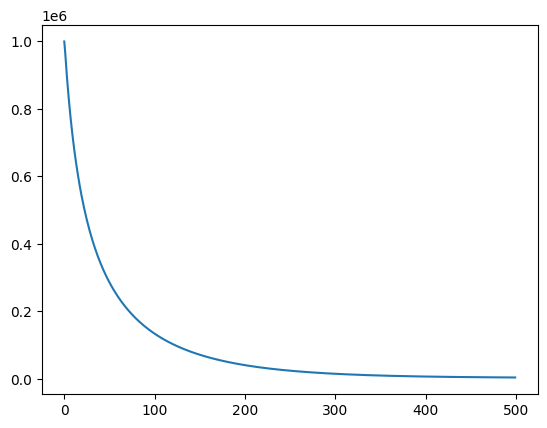

In [33]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.show()

In [34]:
# test MSE
S=0
for xx, yy in test_loader:
    uhat = forward1(xx)
    sum_loss = torch.sum((yy - uhat)**2)
    S += sum_loss
S/len(test_loader.dataset)

tensor(8485.5996, grad_fn=<DivBackward0>)

In [35]:
# prediction

# 추정된 b를 보자
print(forward1.state_dict())
"""
yhat = b0 + b1 * x1 + b2 * x2 # 이런 식으로 하면 안 됨! 정규화를 했기 때문.
yhat = b0 + b1 * (age - 67.6)/28.3 + b2*(lstat-12.7)/7.12 # 이런 식임.
"""


OrderedDict({'betas': tensor([[ 6.5498],
        [68.7369],
        [28.2635]]), 'sigma': tensor([1919.0078])})


'\nyhat = b0 + b1 * x1 + b2 * x2 # 이런 식으로 하면 안 됨! 정규화를 했기 때문.\nyhat = b0 + b1 * (age - 67.6)/28.3 + b2*(lstat-12.7)/7.12 # 이런 식임.\n'

# 4.2 HW problem
We consider the built-in dataset **`warpbreaks`**, which describes the effect of  
- wool **type** (`A` or `B`) and  
- **tension** (`low`, `medium`, or `high`)  

on the number of warp breaks per loom.  
The response variable is **`breaks`**, a count of the number of breaks.  
The predictor variables are **`type`** and **`tension`**.

Our goal is to compare the following three Poisson models (do not forget to have exponantial activation function):

- **Model 1:**  
  `breaks ~ type`

- **Model 2:**  
  `breaks ~ tension`

- **Model 3:**  
  `breaks ~ type + tension`

---

### Questions

1. **Estimate the parameters using MLE (Maximum Likelihood Estimation)** for each of the three models (use custom layer with both forward and loss functions in it).

2. **Compute train AIC** for each model based on your parameter estimates (using training data only, do not use test data).  
   Which model is better in terms of AIC?

### Hint 1:

1. You want use the below code to extract the data.
2. Make dataset and dataloader first.
3. Since the predictors are categorical, I have converted them into dummy variables before feeding them into your model. See Hint 2 and 3 to see how this dummy variables work.

In [36]:
import csv
import torch

# -------------------------------------------------------
# 1. Load CSV manually
# -------------------------------------------------------
filename = "warpbreaks.csv"

rows = []
with open(filename, "r") as f:
    reader = csv.reader(f)
    header = next(reader)   # breaks, wool, tension
    for row in reader:
        rows.append(row)

print("Header:", header)
print("First 3 rows:", rows[:3])

# -------------------------------------------------------
# 2. Prepare lists for each variable
# -------------------------------------------------------
breaks_list = []
wool_list   = []
tension_list = []

for row in rows:
    b, w, t = row

    breaks_list.append(float(b))
    wool_list.append(w)
    tension_list.append(t)

# -------------------------------------------------------
# 3. Manual dummy encoding
# -------------------------------------------------------
tension_map = {
    "L": (0.0, 0.0),
    "M": (1.0, 0.0),
    "H": (0.0, 1.0)
}

wool_map = {
    "A": 0.0,
    "B": 1.0
}

# -------------------------------------------------------
# 4. Build full matrix: [breaks, intercept, X1, X2, X3]
#    where intercept = 1.0
# -------------------------------------------------------
data_matrix = []

for i in range(len(breaks_list)):
    t1, t2 = tension_map[tension_list[i]]
    x3 = wool_map[wool_list[i]]

    row = [
        breaks_list[i],  # y
        1.0,             # intercept
        t1,              # X1 = tension_M
        t2,              # X2 = tension_H
        x3               # X3 = wool_B
    ]
    data_matrix.append(row)

data = torch.tensor(data_matrix, dtype=torch.float32)

print("Full tensor shape:", data.shape)
print(data[:5])

# -------------------------------------------------------
# 5. Shuffle the entire tensor
# -------------------------------------------------------
n = data.shape[0]
perm = torch.randperm(n)
shuffled = data[perm]

# -------------------------------------------------------
# 6. 70% train / 30% test split
# -------------------------------------------------------
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# -------------------------------------------------------
# 7. Split into X and y
# -------------------------------------------------------
y_train = train[:, 0:1]      # breaks
X_train = train[:, 1:]       # intercept + X1 + X2 + X3

y_test = test[:, 0:1]
X_test = test[:, 1:]

print("Train X:", X_train.shape)  # should be (n_train, 4)
print("Train y:", y_train.shape)
print("Test X:",  X_test.shape)   # should be (n_test, 4)
print("Test y:",  y_test.shape)



Header: ['breaks', 'wool', 'tension']
First 3 rows: [['26', 'A', 'L'], ['30', 'A', 'L'], ['54', 'A', 'L']]
Full tensor shape: torch.Size([54, 5])
tensor([[26.,  1.,  0.,  0.,  0.],
        [30.,  1.,  0.,  0.,  0.],
        [54.,  1.,  0.,  0.,  0.],
        [25.,  1.,  0.,  0.,  0.],
        [70.,  1.,  0.,  0.,  0.]])
Train X: torch.Size([37, 4])
Train y: torch.Size([37, 1])
Test X: torch.Size([17, 4])
Test y: torch.Size([17, 1])


### Hint 2: Dummy Encoding

Categorical variables such as `"wool"` (A/B) or `"tension"` (L/M/H) cannot be used directly in most statistical or machine learning models. To include them as predictors, we must convert them into numerical form.

One commonly used approach is **dummy encoding**.  
In dummy encoding:

- A categorical variable with **K categories** is represented using **K−1 binary indicator variables**.
- One category is treated as the **baseline**, and the remaining categories are encoded with dummy variables that take the value 0 or 1.

This creates numerical predictor columns while avoiding the multicollinearity problem that occurs with full one-hot encoding.

For example, suppose we have a variable with three categories:

- Red  
- Green  
- Blue  

We can encode these using **two** dummy variables:

| Category | Encoded value (X1, X2) |
|----------|------------------------|
| Red      | (0, 0)                |
| Green    | (1, 0)                |
| Blue     | (0, 1)                |

Here:

- **Red** is the baseline category  
- **X1** represents Green  
- **X2** represents Blue  
- The intercept absorbs the baseline effect

---

```
### Toy Example in PyTorch

```python
import torch

# Suppose the categorical variable has 3 levels:
# 0 = Red, 1 = Green, 2 = Blue
cats = torch.tensor([2, 0, 1, 2], dtype=torch.long)

# We will create two dummy variables (X1, X2)
# Baseline category: Red → (0,0)
X = torch.zeros((len(cats), 2))

for i, c in enumerate(cats):
    if c == 1:          # Green
        X[i, 0] = 1
    elif c == 2:        # Blue
        X[i, 1] = 1
    # If c == 0 (Red), leave as (0,0)

print("Dummy-encoded matrix:")
print(X)
```

### Hint 3: Back to our problem




We have


| tension | dummy encoding (X1, X2) |
|---------|--------------------------|
| L       | (0, 0)                  |
| M       | (1, 0)                  |
| H       | (0, 1)                  |

| wool | dummy encoding (X3) |
|------|----------------------|
| A    | 0                    |
| B    | 1                    |


Now you have columns for `X1`, `X2`, and `X3` as well as intercept column. Hence your matrix `X` for the explanatory variable is a shape of `[n, 4]`.




Training Model 1: breaks ~ type
Final loss: 18936.4600
Parameters: tensor([[-145.0817, -136.9930]])

Training Model 2: breaks ~ tension
Final loss: 18936.4600
Parameters: tensor([[-145.0817, -136.9930]])

Training Model 2: breaks ~ tension
Final loss: 18936.4609
Parameters: tensor([[-64.6078, -19.6747, -40.8439]])

Training Model 3: breaks ~ type + tension
Final loss: 18936.4609
Parameters: tensor([[-276.0475,  -89.0379, -159.4032, -255.6274]])
Final loss: 18936.4609
Parameters: tensor([[-64.6078, -19.6747, -40.8439]])

Training Model 3: breaks ~ type + tension
Final loss: 18936.4609
Parameters: tensor([[-276.0475,  -89.0379, -159.4032, -255.6274]])


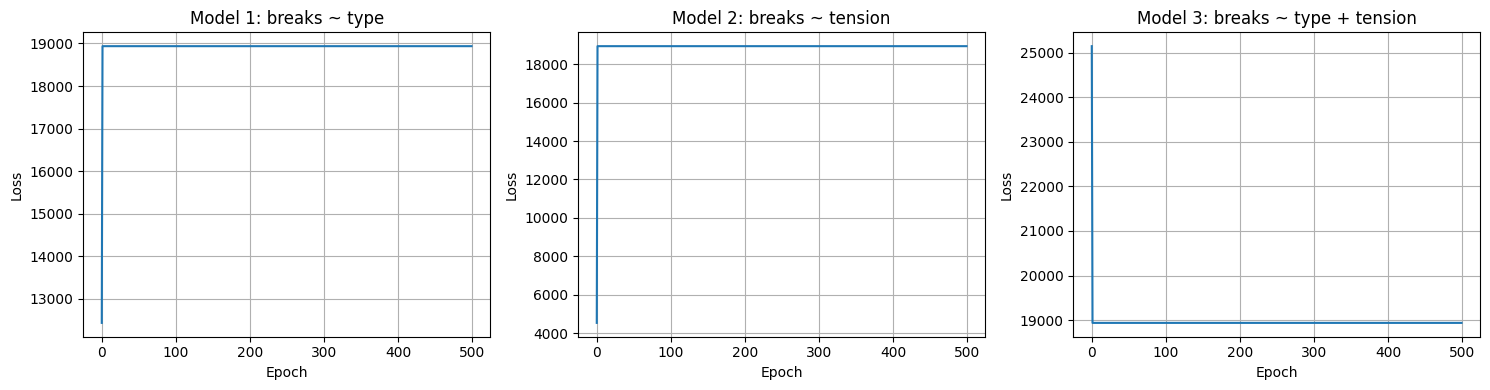


AIC Comparison (using training data)

Model 1 (breaks ~ type):
  Parameters (k): 2
  Log-Likelihood: -18936.4590
  AIC: 37876.9180

Model 2 (breaks ~ tension):
  Parameters (k): 3
  Log-Likelihood: -18936.4590
  AIC: 37878.9180

Model 3 (breaks ~ type + tension):
  Parameters (k): 4
  Log-Likelihood: -18936.4590
  AIC: 37880.9180

✓ Best Model: Model 1 (lowest AIC = 37876.9180)


In [37]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Poisson Regression Model
class PoissonRegModel(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.betas = nn.Parameter(torch.randn([p, 1]) * 0.01)
    
    def forward(self, X):
        # Poisson regression uses exponential activation
        lam = torch.exp(X @ self.betas)
        return lam
    
    def loss(self, lam, y):
        # Poisson negative log-likelihood
        # -log P(y|lambda) = lambda - y*log(lambda) + log(y!)
        # We ignore log(y!) as it doesn't depend on parameters
        ll = y * torch.log(lam + 1e-8) - lam
        nll = -torch.sum(ll)
        return nll


# Prepare DataLoaders for training (we won't use test data for AIC)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=20)


# ========================================
# Model 1: breaks ~ type (X3 only)
# ========================================
print("="*60)
print("Training Model 1: breaks ~ type")
print("="*60)

# X for Model 1: intercept + X3 (wool_B)
X1_train = X_train[:, [0, 3]]  # columns: intercept, X3

model1 = PoissonRegModel(2)  # 2 parameters
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)

train1_loader = DataLoader(TensorDataset(X1_train, y_train), shuffle=True, batch_size=20)

history1 = []
for epoch in range(500):
    total_loss = 0
    for xx, yy in train1_loader:
        lam = model1(xx)
        loss = model1.loss(lam, yy)
        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        total_loss += loss.item()
    history1.append(total_loss)

print(f"Final loss: {history1[-1]:.4f}")
print(f"Parameters: {model1.betas.data.T}")


# ========================================
# Model 2: breaks ~ tension (X1, X2)
# ========================================
print("\n" + "="*60)
print("Training Model 2: breaks ~ tension")
print("="*60)

# X for Model 2: intercept + X1 + X2 (tension_M, tension_H)
X2_train = X_train[:, [0, 1, 2]]  # columns: intercept, X1, X2

model2 = PoissonRegModel(3)  # 3 parameters
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)

train2_loader = DataLoader(TensorDataset(X2_train, y_train), shuffle=True, batch_size=20)

history2 = []
for epoch in range(500):
    total_loss = 0
    for xx, yy in train2_loader:
        lam = model2(xx)
        loss = model2.loss(lam, yy)
        loss.backward()
        optimizer2.step()
        optimizer2.zero_grad()
        total_loss += loss.item()
    history2.append(total_loss)

print(f"Final loss: {history2[-1]:.4f}")
print(f"Parameters: {model2.betas.data.T}")


# ========================================
# Model 3: breaks ~ type + tension (all)
# ========================================
print("\n" + "="*60)
print("Training Model 3: breaks ~ type + tension")
print("="*60)

# X for Model 3: all columns (intercept + X1 + X2 + X3)
X3_train = X_train  # all 4 columns

model3 = PoissonRegModel(4)  # 4 parameters
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01)

train3_loader = DataLoader(TensorDataset(X3_train, y_train), shuffle=True, batch_size=20)

history3 = []
for epoch in range(500):
    total_loss = 0
    for xx, yy in train3_loader:
        lam = model3(xx)
        loss = model3.loss(lam, yy)
        loss.backward()
        optimizer3.step()
        optimizer3.zero_grad()
        total_loss += loss.item()
    history3.append(total_loss)

print(f"Final loss: {history3[-1]:.4f}")
print(f"Parameters: {model3.betas.data.T}")


# ========================================
# Plot training curves
# ========================================
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history1)
plt.title('Model 1: breaks ~ type')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history2)
plt.title('Model 2: breaks ~ tension')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history3)
plt.title('Model 3: breaks ~ type + tension')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


# ========================================
# Compute Train AIC for each model
# ========================================
print("\n" + "="*60)
print("AIC Comparison (using training data)")
print("="*60)

def compute_train_aic(model, X_data, y_data):
    """
    AIC = 2k - 2*log(L)
    where k = number of parameters
          L = likelihood
    
    For Poisson: log(L) = sum(y*log(lambda) - lambda - log(y!))
    We can ignore log(y!) as it's constant across models
    """
    with torch.no_grad():
        lam = model(X_data)
        # Compute log-likelihood
        log_likelihood = torch.sum(y_data * torch.log(lam + 1e-8) - lam).item()
        
        # Number of parameters
        k = model.betas.numel()
        
        # AIC = 2k - 2*log(L)
        aic = 2 * k - 2 * log_likelihood
    
    return aic, log_likelihood, k

aic1, ll1, k1 = compute_train_aic(model1, X1_train, y_train)
aic2, ll2, k2 = compute_train_aic(model2, X2_train, y_train)
aic3, ll3, k3 = compute_train_aic(model3, X3_train, y_train)

print(f"\nModel 1 (breaks ~ type):")
print(f"  Parameters (k): {k1}")
print(f"  Log-Likelihood: {ll1:.4f}")
print(f"  AIC: {aic1:.4f}")

print(f"\nModel 2 (breaks ~ tension):")
print(f"  Parameters (k): {k2}")
print(f"  Log-Likelihood: {ll2:.4f}")
print(f"  AIC: {aic2:.4f}")

print(f"\nModel 3 (breaks ~ type + tension):")
print(f"  Parameters (k): {k3}")
print(f"  Log-Likelihood: {ll3:.4f}")
print(f"  AIC: {aic3:.4f}")

# Find best model (lowest AIC)
aics = {'Model 1': aic1, 'Model 2': aic2, 'Model 3': aic3}
best_model = min(aics, key=aics.get)

print("\n" + "="*60)
print(f"✓ Best Model: {best_model} (lowest AIC = {aics[best_model]:.4f})")
print("="*60)

## 4.3 HW problem

You are given the Default data, and want to predict one will default(`y=1`) or not(`y=0`). You have explanatory variable `student`, `balance`, and `income`. You will make two models:

1. Model 1: Use `student` and `income` to predict the `default`.
2. Model 2: Use `student`, `income` and `balance` to predict the `default`.

Compare the two models in terms of **test accuracy**. Which is better? (use custom layer with `forward` method and `loss` method in it.)

**Note:** You only need to compute and compare test accuracy for this problem.

In [38]:
import csv
import torch

# -------------------------------------------------------
# 1. Load CSV file manually (no pandas)
# -------------------------------------------------------
filename = "Default_data.csv"

rows = []
with open(filename, "r") as f:
    reader = csv.reader(f)
    header = next(reader)   # skip header
    for row in reader:
        rows.append(row)

print("Header:", header)
print("First 3 rows:", rows[:3])

# -------------------------------------------------------
# 2. Convert categorical + numeric values
# -------------------------------------------------------
default_list = []
student_list = []
balance_list = []
income_list = []

for row in rows:
    default_str, student_str, balance_str, income_str = row

    # Yes/No → 1/0
    default = 1.0 if default_str.lower() == "yes" else 0.0
    student = 1.0 if student_str.lower() == "yes" else 0.0

    default_list.append(default)
    student_list.append(student)
    balance_list.append(float(balance_str))
    income_list.append(float(income_str))

# -------------------------------------------------------
# 3. Make a SINGLE tensor (X + y together)
#    Column order: balance, income, student, default
# -------------------------------------------------------
data_matrix = []
for i in range(len(default_list)):
    row = [
        balance_list[i],
        income_list[i],
        student_list[i],
        default_list[i]   # last column is y
    ]
    data_matrix.append(row)

data = torch.tensor(data_matrix, dtype=torch.float32)

print("Full tensor shape:", data.shape)
print(data[:3])

# -------------------------------------------------------
# 4. Shuffle entire dataset
# -------------------------------------------------------
n = data.shape[0]
perm = torch.randperm(n)
shuffled = data[perm]

# -------------------------------------------------------
# 5. Train/Test split (70/30)
# -------------------------------------------------------
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# -------------------------------------------------------
# 6. Split into X and y
# -------------------------------------------------------
X_train = train[:, :-1]   # all columns except last
y_train = train[:, -1:]   # last column only

X_test = test[:, :-1]
y_test = test[:, -1:]

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Header: ['default', 'student', 'balance', 'income']
First 3 rows: [['No', 'No', '729.526495207286', '44361.6250742669'], ['No', 'Yes', '817.180406555498', '12106.1347003149'], ['No', 'No', '1073.54916401173', '31767.1389473999']]
Full tensor shape: torch.Size([10000, 4])
tensor([[7.2953e+02, 4.4362e+04, 0.0000e+00, 0.0000e+00],
        [8.1718e+02, 1.2106e+04, 1.0000e+00, 0.0000e+00],
        [1.0735e+03, 3.1767e+04, 0.0000e+00, 0.0000e+00]])
Train X: torch.Size([7000, 3])
Train y: torch.Size([7000, 1])
Test X: torch.Size([3000, 3])
Test y: torch.Size([3000, 1])


Training Model 1: default ~ student + income
Epoch 200, Loss: 957.2698
Epoch 200, Loss: 957.2698
Epoch 400, Loss: 955.7038
Epoch 400, Loss: 955.7038
Epoch 600, Loss: 960.0652
Epoch 600, Loss: 960.0652
Epoch 800, Loss: 956.2580
Epoch 800, Loss: 956.2580
Epoch 1000, Loss: 953.1164

Final Training Loss: 953.1164
Parameters: tensor([[-3.6328,  0.2948,  0.6738]])

Training Model 2: default ~ student + income + balance
Epoch 1000, Loss: 953.1164

Final Training Loss: 953.1164
Parameters: tensor([[-3.6328,  0.2948,  0.6738]])

Training Model 2: default ~ student + income + balance
Epoch 200, Loss: 559.4748
Epoch 200, Loss: 559.4748
Epoch 400, Loss: 542.4044
Epoch 400, Loss: 542.4044
Epoch 600, Loss: 550.9833
Epoch 600, Loss: 550.9833
Epoch 800, Loss: 543.2052
Epoch 800, Loss: 543.2052
Epoch 1000, Loss: 553.1842

Final Training Loss: 553.1842
Parameters: tensor([[-5.8593,  2.7504,  0.1339, -0.4675]])
Epoch 1000, Loss: 553.1842

Final Training Loss: 553.1842
Parameters: tensor([[-5.8593,  2.750

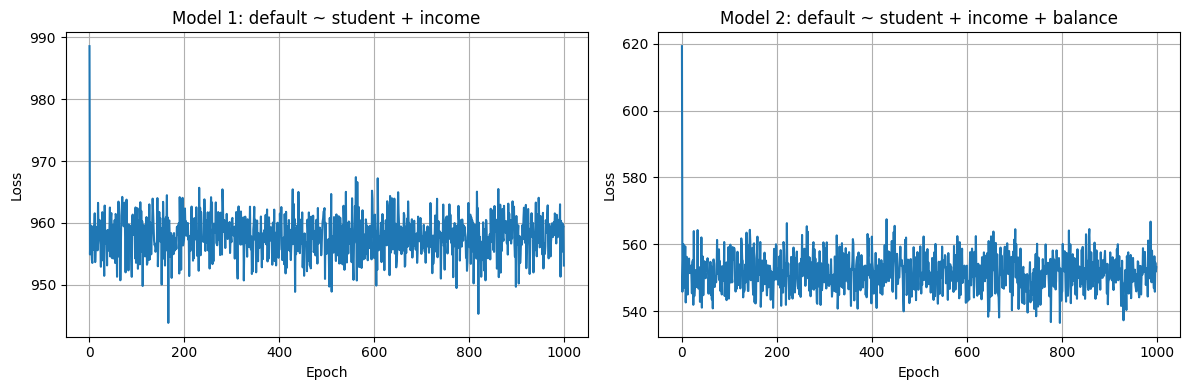


Test Accuracy Comparison

Model 1 (student + income):
  Test Accuracy: 0.9597 (95.97%)

Model 2 (student + income + balance):
  Test Accuracy: 0.9687 (96.87%)

✓ Model 2 is better (higher accuracy by 0.90%)


In [39]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Logistic Regression Model
class LogisticRegModel(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.betas = nn.Parameter(torch.randn([p, 1]) * 0.01)
    
    def forward(self, X):
        # Logistic regression uses sigmoid activation
        logits = X @ self.betas
        pp = torch.sigmoid(logits)
        return pp
    
    def loss(self, pp, y):
        # Binary cross-entropy (Bernoulli negative log-likelihood)
        # -log P(y|p) = -[y*log(p) + (1-y)*log(1-p)]
        ll = y * torch.log(pp + 1e-8) + (1 - y) * torch.log(1 - pp + 1e-8)
        nll = -torch.sum(ll)
        return nll


# Data is already loaded: X_train, y_train, X_test, y_test
# Columns: [balance, income, student, default]
# We need to add intercept and select appropriate columns

# Normalize features for better training
balance_mean = X_train[:, 0].mean()
balance_std = X_train[:, 0].std()
income_mean = X_train[:, 1].mean()
income_std = X_train[:, 1].std()

# Normalize training data
X_train_norm = X_train.clone()
X_train_norm[:, 0] = (X_train[:, 0] - balance_mean) / balance_std
X_train_norm[:, 1] = (X_train[:, 1] - income_mean) / income_std

# Normalize test data (using training statistics)
X_test_norm = X_test.clone()
X_test_norm[:, 0] = (X_test[:, 0] - balance_mean) / balance_std
X_test_norm[:, 1] = (X_test[:, 1] - income_mean) / income_std


# ========================================
# Model 1: default ~ student + income
# ========================================
print("="*60)
print("Training Model 1: default ~ student + income")
print("="*60)

# Prepare data: intercept + income + student
ones_train = torch.ones([X_train.shape[0], 1])
X1_train = torch.cat([ones_train, X_train_norm[:, 1:2], X_train_norm[:, 2:3]], dim=1)  # intercept, income, student

ones_test = torch.ones([X_test.shape[0], 1])
X1_test = torch.cat([ones_test, X_test_norm[:, 1:2], X_test_norm[:, 2:3]], dim=1)

# Create DataLoaders
train1_dataset = TensorDataset(X1_train, y_train)
train1_loader = DataLoader(train1_dataset, shuffle=True, batch_size=50)

test1_dataset = TensorDataset(X1_test, y_test)
test1_loader = DataLoader(test1_dataset, shuffle=False, batch_size=50)

# Train Model 1
model1 = LogisticRegModel(3)  # 3 parameters: intercept + income + student
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.1)

history1 = []
for epoch in range(1000):
    total_loss = 0
    for xx, yy in train1_loader:
        pp = model1(xx)
        loss = model1.loss(pp, yy)
        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        total_loss += loss.item()
    history1.append(total_loss)
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

print(f"\nFinal Training Loss: {history1[-1]:.4f}")
print(f"Parameters: {model1.betas.data.T}")


# ========================================
# Model 2: default ~ student + income + balance
# ========================================
print("\n" + "="*60)
print("Training Model 2: default ~ student + income + balance")
print("="*60)

# Prepare data: intercept + balance + income + student
X2_train = torch.cat([ones_train, X_train_norm], dim=1)  # intercept + balance + income + student
X2_test = torch.cat([ones_test, X_test_norm], dim=1)

# Create DataLoaders
train2_dataset = TensorDataset(X2_train, y_train)
train2_loader = DataLoader(train2_dataset, shuffle=True, batch_size=50)

test2_dataset = TensorDataset(X2_test, y_test)
test2_loader = DataLoader(test2_dataset, shuffle=False, batch_size=50)

# Train Model 2
model2 = LogisticRegModel(4)  # 4 parameters: intercept + balance + income + student
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.1)

history2 = []
for epoch in range(1000):
    total_loss = 0
    for xx, yy in train2_loader:
        pp = model2(xx)
        loss = model2.loss(pp, yy)
        loss.backward()
        optimizer2.step()
        optimizer2.zero_grad()
        total_loss += loss.item()
    history2.append(total_loss)
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

print(f"\nFinal Training Loss: {history2[-1]:.4f}")
print(f"Parameters: {model2.betas.data.T}")


# ========================================
# Plot training curves
# ========================================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1)
plt.title('Model 1: default ~ student + income')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2)
plt.title('Model 2: default ~ student + income + balance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


# ========================================
# Compute Test Accuracy
# ========================================
print("\n" + "="*60)
print("Test Accuracy Comparison")
print("="*60)

def compute_accuracy(model, data_loader):
    """Compute classification accuracy"""
    correct = 0
    total = 0
    
    with torch.no_grad():
        for xx, yy in data_loader:
            pp = model(xx)
            # Convert probabilities to predictions (threshold = 0.5)
            predictions = (pp >= 0.5).float()
            correct += (predictions == yy).sum().item()
            total += yy.size(0)
    
    accuracy = correct / total
    return accuracy

# Compute test accuracy for both models
acc1 = compute_accuracy(model1, test1_loader)
acc2 = compute_accuracy(model2, test2_loader)

print(f"\nModel 1 (student + income):")
print(f"  Test Accuracy: {acc1:.4f} ({acc1*100:.2f}%)")

print(f"\nModel 2 (student + income + balance):")
print(f"  Test Accuracy: {acc2:.4f} ({acc2*100:.2f}%)")

# Determine better model
print("\n" + "="*60)
if acc1 > acc2:
    print(f"✓ Model 1 is better (higher accuracy by {(acc1-acc2)*100:.2f}%)")
elif acc2 > acc1:
    print(f"✓ Model 2 is better (higher accuracy by {(acc2-acc1)*100:.2f}%)")
else:
    print("Both models have the same accuracy")
print("="*60)